In [56]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('consolidated_aras_dataset.csv')

df_activities = pd.read_csv('activities.csv', delimiter='\t',index_col = 'ID')

print("Shape of Dataset: ",df.shape)
print("Shape of Activities: ",df_activities.shape)

Shape of Dataset:  (5184000, 23)
Shape of Activities:  (27, 1)


In [57]:
def split_house_data(df, house_name, df_activities, start_time):
    """This method will add timestamps to df_house_A and df_house_B dataframes. and Renames columns Resident_A, Resident_B for better understanding of what they represent"""
    house_df = df[df['House'] == house_name].copy()
    house_df['time_stamp'] = pd.date_range(start_time, periods=len(house_df), freq='S')
    activity_cols = ['Activity_1', 'Activity_2']
    resident_cols = ['Resident_A', 'Resident_B']
    for i, col in enumerate(activity_cols):
        activity_values = df_activities.loc[house_df[resident_cols[i]], 'ACTIVITY'].values
        house_df[col] = activity_values
    #Resindent A = Resident 1 in both houses. Same for the Resident B
    house_df.rename(columns = {'Resident_A':'Resident_1', 'Resident_B':'Resident_2'}, inplace = True)
    return house_df

start_time = pd.Timestamp('2023-01-01')
df_house_A = split_house_data(df, 'A', df_activities, start_time)
df_house_B = split_house_data(df, 'B', df_activities, start_time)

#Saving dataset for for House A
# df_house_A.drop(['Activity_1', 'Activity_2'], axis = 1, inplace = True)
df_house_A.to_csv("House_A.csv", index = False)

#Saving dataset for House B
# df_house_B.drop(['Activity_1', 'Activity_2'], axis = 1, inplace = True)
df_house_B.to_csv("House_B.csv", index = False)


In [58]:
df_house_A.columns
df_house_B.columns

Index(['Photocell_1', 'Photocell_2', 'IR_1', 'Force_Sensor_1',
       'Force_Sensor_2', 'Distance_Sensor_3', 'Distance_Sensor_4',
       'Photocell_3', 'Photocell_4', 'Photocell_5', 'Photocell_6',
       'Contact_Sensor_1', 'Contact_Sensor_2', 'Contact_Sensor_3', 'Sonar_1',
       'Sonar_2', 'Distance_Sensor_2', 'Distance_Sensor_3.1', 'Tempurature_1',
       'Force_Sensor_3', 'Resident_1', 'Resident_2', 'House', 'time_stamp',
       'Activity_1', 'Activity_2'],
      dtype='object')

In [59]:
sensor_cols = ['Photocell_1', 'Photocell_2', 'IR_1', 'Force_Sensor_1', 'Force_Sensor_2', 'Distance_Sensor_3', 'Distance_Sensor_4', 'Photocell_3', 'Photocell_4', 'Photocell_5', 'Photocell_6','Contact_Sensor_1', 'Contact_Sensor_2', 'Contact_Sensor_3', 'Sonar_1','Sonar_2', 'Distance_Sensor_2', 'Distance_Sensor_3.1', 'Tempurature_1','Force_Sensor_3']
cols = ['time_stamp','Photocell_1', 'Photocell_2', 'IR_1', 'Force_Sensor_1', 'Force_Sensor_2', 'Distance_Sensor_3', 'Distance_Sensor_4','Photocell_3', 'Photocell_4', 'Photocell_5', 'Photocell_6','Contact_Sensor_1', 'Contact_Sensor_2', 'Contact_Sensor_3', 'Sonar_1','Sonar_2', 'Distance_Sensor_2', 'Distance_Sensor_3.1', 'Tempurature_1','Force_Sensor_3']

In [60]:
def group_activities(df, activity_col, resident):   
        """
        This method groups data taking continuous values in dataset. For grouped reading it will prepare start and end time for that activity that is observed.
        """
        df_temp = df[cols + [activity_col]].copy()
        df_temp['occurrence'] = (df_temp[activity_col] != df_temp[activity_col].shift()).cumsum()
        grouped = df_temp.groupby(['occurrence', activity_col]).agg(start_time=('time_stamp', 'min'), end_time=('time_stamp', 'max'))
        grouped.reset_index(inplace=True)
        grouped['Resident'] = resident
        grouped.rename(columns = {activity_col: 'Activity'}, inplace = True)
        grouped.drop('occurrence', axis=1, inplace=True)
        return grouped

results = []
results.append(group_activities(df_house_A, 'Activity_1', 'A1'))
results.append(group_activities(df_house_A, 'Activity_2', 'A2'))
results.append(group_activities(df_house_B, 'Activity_1', 'B1'))
results.append(group_activities(df_house_B, 'Activity_2', 'B2'))

#Importing grouped data for tableau dashboard
df_grouped = pd.concat(results)
df_grouped.to_csv("grouped_data.csv", index = False)

As per the dataset description the residents were asked to label what they were doing over the time during the day and they have added user mention activity label to sensor readings. 

Since each row in dataset represents sensor readings for both residents. I'm cheching for which sensors were generating reading when one of the user of going out, which gives us with only the readings for one activity.  Below code implements the same by grouping and taking average of the readings filter by Activiy = 2 for both residents.

In [61]:
threshold = 0.6
traversed_list = []
sensor_activity_dependency = {}
# sensor_cols = ['Photocell_1', 'Photocell_2', 'IR_1', 'Force_Sensor_1', 'Force_Sensor_2', 'Distance_Sensor_3', 'Distance_Sensor_4', 'Photocell_3', 'Photocell_4', 'Photocell_5', 'Photocell_6','Contact_Sensor_1', 'Contact_Sensor_2', 'Contact_Sensor_3', 'Sonar_1','Sonar_2', 'Distance_Sensor_2', 'Distance_Sensor_3.1', 'Tempurature_1','Force_Sensor_3']

def identify_sensor_activity_dependencies(df, resident_col, threshold = 0.6):
    act = df[resident_col].unique()
    for i in act:
        if i not in [1, 2]:
            df_resident = df[df[resident_col] == i][sensor_cols]
            cols_above_threshold = list(df_resident.columns[df_resident.max() > threshold])
            if i not in sensor_activity_dependency:
                sensor_activity_dependency[i] = cols_above_threshold
            else:
                sensor_activity_dependency[i] += cols_above_threshold
                
# Calculate sensor activity dependencies for Resident_1 in df_A
df1 = df_house_A[df_house_A['Resident_1'] == 2]
df1 = df1.groupby(['Resident_1', 'Resident_2']).mean()[:]
df1.reset_index(inplace=True)
identify_sensor_activity_dependencies(df1, 'Resident_2')

# Calculate sensor activity dependencies for Resident_2 in df_A
df1 = df_house_A[df_house_A['Resident_2'] == 2]
df1 = df1.groupby(['Resident_1', 'Resident_2']).mean()[:]
df1.reset_index(inplace=True)
identify_sensor_activity_dependencies(df1, 'Resident_1')

print("For House A")
# Print sensor activity dependencies for each resident in House A
for i in sensor_activity_dependency:
    sensor_activity_dependency[i] = list(set(sensor_activity_dependency[i]))
    print(df_activities.loc[i, 'ACTIVITY'], ' : ', sensor_activity_dependency[i])

traversed_list = []
sensor_activity_dependency = {}

df1 = df_house_B[df_house_B['Resident_1'] == 2]
df1 = df1.groupby(['Resident_1', 'Resident_2']).mean()[:]
df1.reset_index(inplace=True)
identify_sensor_activity_dependencies(df1, 'Resident_2', 0.3)

# Calculate sensor activity dependencies for Resident_2 in df_A
df1 = df_house_B[df_house_B['Resident_2'] == 2]
df1 = df1.groupby(['Resident_1', 'Resident_2']).mean()[:]
df1.reset_index(inplace=True)
identify_sensor_activity_dependencies(df1, 'Resident_1', 0.3)


print()
print("For House B")
# Print sensor activity dependencies for each resident in House A
for i in sensor_activity_dependency:
    sensor_activity_dependency[i] = list(set(sensor_activity_dependency[i]))
    print(df_activities.loc[i, 'ACTIVITY'], ' : ', sensor_activity_dependency[i])

For House A
Preparing Dinner  :  ['Tempurature_1']
Washing Dishes  :  ['Sonar_2']
Having Snack  :  []
Watching TV  :  []
Having Shower  :  ['Contact_Sensor_2']
Toileting  :  ['Contact_Sensor_2', 'Distance_Sensor_3.1']
Napping  :  ['Tempurature_1', 'Force_Sensor_2']
Using Internet  :  []
Laundry  :  []
Brushing Teeth  :  []
Talking on the Phone  :  []
Changing Clothes  :  []
Preparing Breakfast  :  ['Tempurature_1']
Having Breakfast  :  ['Distance_Sensor_3']
Preparing Lunch  :  ['Tempurature_1']
Having Lunch  :  []
Having Dinner  :  ['Distance_Sensor_3']
Sleeping  :  ['Force_Sensor_1']
Studying  :  []
Reading Book  :  ['Force_Sensor_2']
Listening to Music  :  []
Cleaning  :  []
Having Conversation  :  ['Force_Sensor_1']
Having Guest  :  ['Contact_Sensor_2', 'Force_Sensor_1', 'Force_Sensor_2']

For House B
Toileting  :  ['Force_Sensor_3']
Preparing Breakfast  :  ['Tempurature_1']
Having Breakfast  :  ['Photocell_4']
Preparing Lunch  :  ['Tempurature_1']
Having Lunch  :  ['Photocell_4']
P

In [85]:
#Duration for each activity
df_grouped['Duration'] = (df_grouped['end_time'] - df_grouped['start_time']).dt.total_seconds()
df_grouped_activity = df_grouped.groupby(['Activity', 'Resident']).mean()

df_grouped_activity['Duration H:MM '] = np.where(df_grouped_activity['Duration'] >= 3600, 
                                  pd.to_datetime(df_grouped_activity['Duration'], unit='s').dt.strftime('%HH %M min'),
                                  pd.to_datetime(df_grouped_activity['Duration'], unit='s').dt.strftime('%M min'))
df_grouped_activity.to_csv("GroupedData.csv")



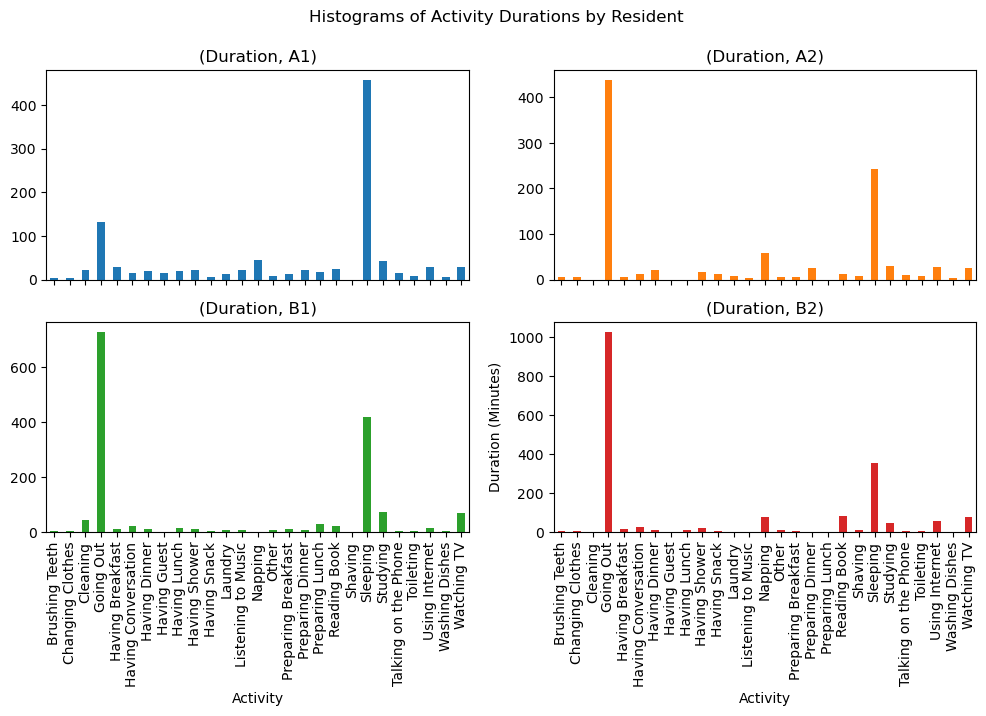

In [105]:
df_activity_avg = df_grouped.groupby(['Activity', 'Resident']).mean()
df_activity_avg['Duration'] = df_activity_avg['Duration']//60 
reshaped_data = df_activity_avg.unstack()

# Create a histogram for each resident
reshaped_data.plot(kind='bar', subplots=True, layout=(2,2), figsize=(12, 6), legend=False)

# Set axis labels and title
plt.xlabel('Activity')
plt.ylabel('Duration (Minutes)')
plt.suptitle('Avg of Activity Durations by Resident')

plt.show()

In [104]:
df_activity_avg.reset_index(inplace = True)
#To check if any resident doesn't perform any of activities
print(df_activity_avg[(df_activity_avg['Resident'] == 'A1') & (df_activity_avg['Duration'] <=0)])
print(df_activity_avg[(df_activity_avg['Resident'] == 'A2') & (df_activity_avg['Duration'] <=0)]) 
print(df_activity_avg[(df_activity_avg['Resident'] == 'B1') & (df_activity_avg['Duration'] <=0)]) 
print(df_activity_avg[(df_activity_avg['Resident'] == 'B2') & (df_activity_avg['Duration'] <=0)]) 

Empty DataFrame
Columns: [level_0, index, Activity, Resident, Duration]
Index: []
Empty DataFrame
Columns: [level_0, index, Activity, Resident, Duration]
Index: []
Empty DataFrame
Columns: [level_0, index, Activity, Resident, Duration]
Index: []
Empty DataFrame
Columns: [level_0, index, Activity, Resident, Duration]
Index: []


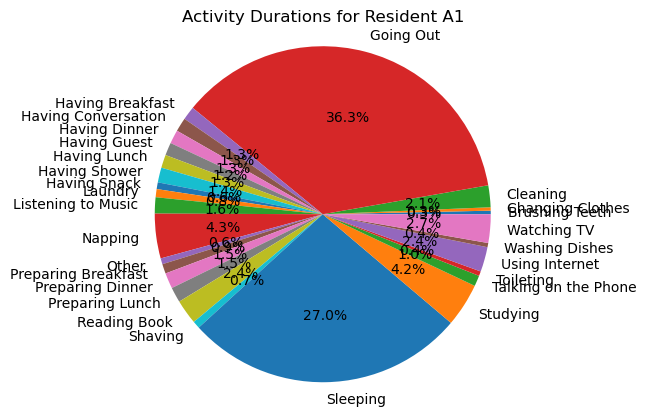

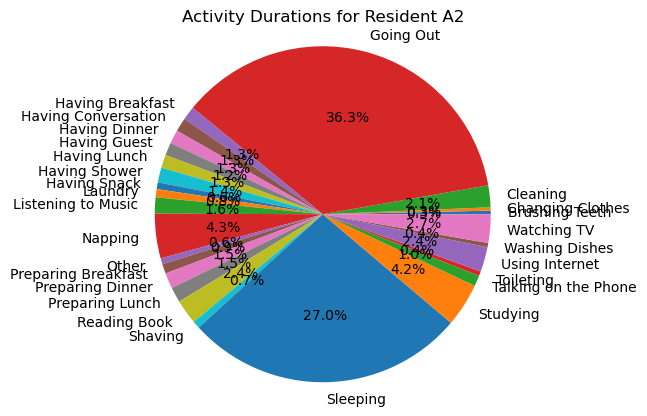

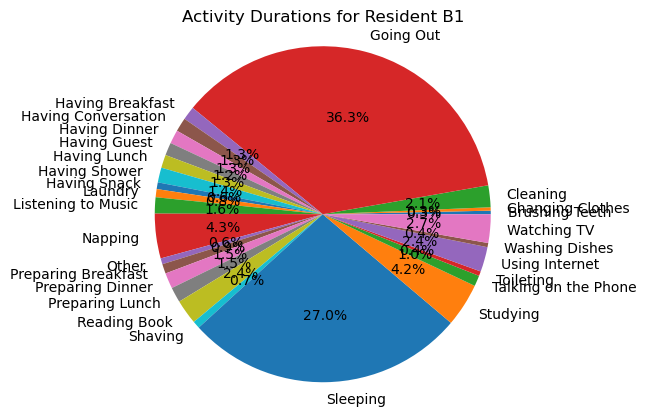

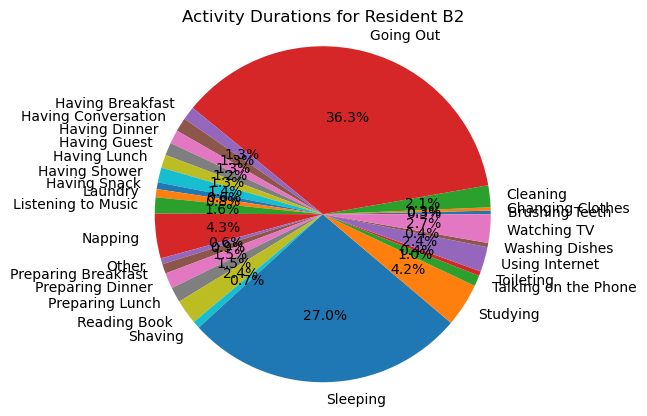

In [113]:
residents = df_grouped['Resident'].unique()
# Loop over each resident and plot a pie chart
for resident in residents:
    # Subset the data for the current resident
    data = df_grouped[df_grouped['Resident'] == resident]
    
    # Calculate the total duration of each activity for the current resident
    activity_durations = df_grouped.groupby('Activity')['Duration'].mean()
    
    # Plot a pie chart for the current resident
    plt.figure()
    plt.pie(activity_durations, labels=activity_durations.index, autopct='%1.1f%%')
    plt.title('Activity Durations for Resident {}'.format(resident))
    plt.axis('equal')
    
# Show the plots
plt.show()

In [114]:
activity_counts = df_grouped['Activity'].value_counts()
activity_counts_A1 = df_grouped[df_grouped['Resident'] == 'A1']['Activity'].value_counts()

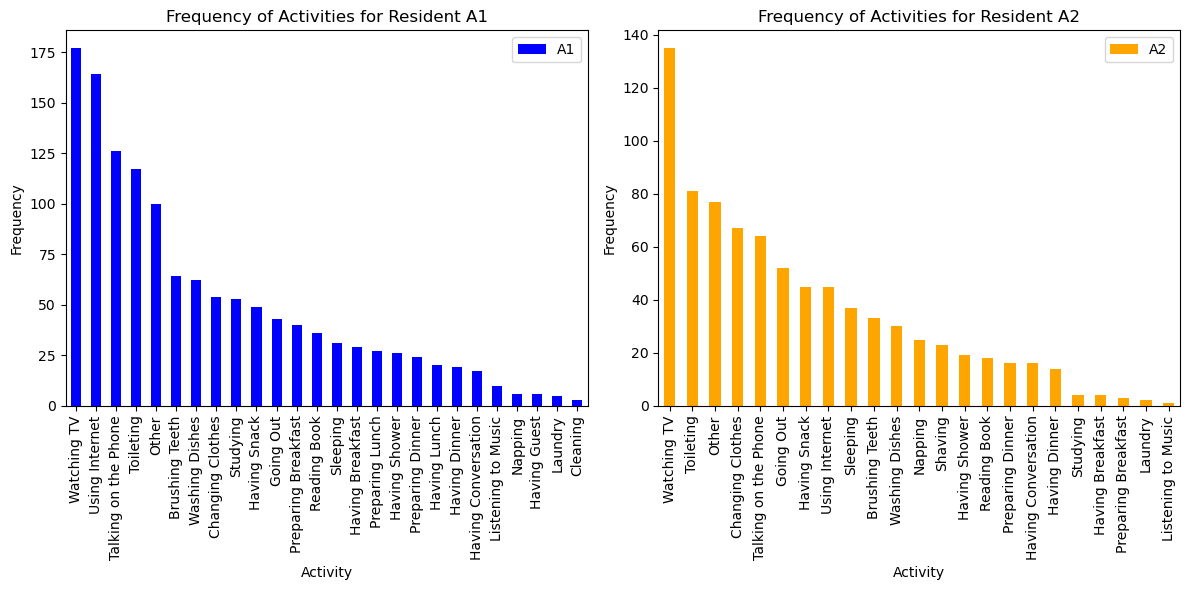

In [124]:
# Get activity counts for each resident in House A
activity_counts_A1 = df_grouped[df_grouped['Resident'] == 'A1']['Activity'].value_counts()
activity_counts_A2 = df_grouped[df_grouped['Resident'] == 'A2']['Activity'].value_counts()

# Create a figure with subplots for each resident
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot the activity counts for each resident
activity_counts_A1.plot(kind='bar', ax=axs[0], color='blue')
activity_counts_A2.plot(kind='bar', ax=axs[1], color='orange')

# Set axis labels and title
axs[0].set_xlabel('Activity')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Frequency of Activities for Resident A1')
axs[1].set_xlabel('Activity')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Frequency of Activities for Resident A2')

# Set legend
axs[0].legend(['A1'])
axs[1].legend(['A2'])

# Display the plot
plt.tight_layout()
plt.show()


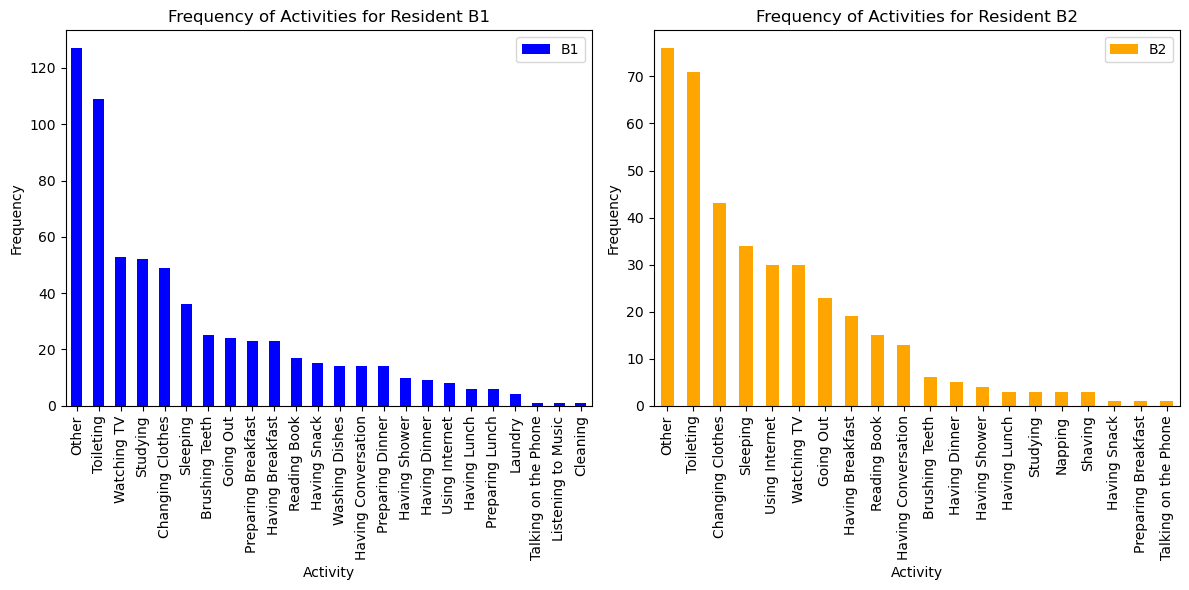

In [125]:
# Get activity counts for each resident in House B
activity_counts_B1 = df_grouped[df_grouped['Resident'] == 'B1']['Activity'].value_counts()
activity_counts_B2 = df_grouped[df_grouped['Resident'] == 'B2']['Activity'].value_counts()

# Create a figure with subplots for each resident
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot the activity counts for each resident
activity_counts_B1.plot(kind='bar', ax=axs[0], color='blue')
activity_counts_B2.plot(kind='bar', ax=axs[1], color='orange')

# Set axis labels and title
axs[0].set_xlabel('Activity')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Frequency of Activities for Resident B1')
axs[1].set_xlabel('Activity')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Frequency of Activities for Resident B2')

# Set legend
axs[0].legend(['B1'])
axs[1].legend(['B2'])

# Display the plot
plt.tight_layout()
plt.show()
